### Requirements

In [1]:
!pip install xgboost

In [5]:
"""Since this notebook was run on Google Colab, the below code block is necessary to store and fetch data for the program."""
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import preprocessing,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report,recall_score,precision_score,f1_score
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.utils import class_weight,shuffle
import string
from statistics import mean
import xgboost as xgb

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
stopword = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

### Handling the Dataset

In [6]:
# This data was taken from csv and dumped into a pickle file
records = pd.read_pickle('/content/gdrive/MyDrive/Research/product_classify/record_dump.pkl')
records

,brand,crawl_timestamp,description,discounted_price,image,is_FK_Advantage_product,overall_rating,pid,product_category_tree,product_name,product_rating,product_specifications,product_url,retail_price,uniq_id
0,Alisha,2016-03-25 22:59:23 +0000,Key Features of Alisha Solid Women's Cycling S...,379,"[""http://img5a.flixcart.com/image/short/u/4/a/...",FALSE,No rating available,SRTEH2FF9KEDEFGF,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Alisha Solid Women's Cycling Shorts,No rating available,"{""product_specification""=>[{""key""=>""Number of ...",http://www.flipkart.com/alisha-solid-women-s-c...,999,c2d766ca982eca8304150849735ffef9
1,FabHomeDecor,2016-03-25 22:59:23 +0000,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,22646,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",FALSE,No rating available,SBEEH3QGU7MFYJFY,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed,No rating available,"{""product_specification""=>[{""key""=>""Installati...",http://www.flipkart.com/fabhomedecor-fabric-do...,32157,7f7036a6d550aaa89d34c77bd39a5e48
2,AW,2016-03-25 22:59:23 +0000,Key Features of AW Bellies Sandals Wedges Heel...,499,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",FALSE,No rating available,SHOEH4GRSUBJGZXE,"[""Footwear >> Women's Footwear >> Ballerinas >...",AW Bellies,No rating available,"{""product_specification""=>[{""key""=>""Ideal For""...",http://www.flipkart.com/aw-bellies/p/itmeh4grg...,999,f449ec65dcbc041b6ae5e6a32717d01b
3,Alisha,2016-03-25 22:59:23 +0000,Key Features of Alisha Solid Women's Cycling S...,267,"[""http://img5a.flixcart.com/image/short/6/2/h/...",FALSE,No rating available,SRTEH2F6HUZMQ6SJ,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Alisha Solid Women's Cycling Shorts,No rating available,"{""product_specification""=>[{""key""=>""Number of ...",http://www.flipkart.com/alisha-solid-women-s-c...,699,0973b37acd0c664e3de26e97e5571454
4,Sicons,2016-03-25 22:59:23 +0000,Specifications of Sicons All Purpose Arnica Do...,210,"[""http://img5a.flixcart.com/image/pet-shampoo/...",FALSE,No rating available,PSOEH3ZYDMSYARJ5,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Sicons All Purpose Arnica Dog Shampoo,No rating available,"{""product_specification""=>[{""key""=>""Pet Type"",...",http://www.flipkart.com/sicons-all-purpose-arn...,220,bc940ea42ee6bef5ac7cea3fb5cfbee7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,WallDesign,2015-12-01 10:15:43 +0000,Buy WallDesign Small Vinyl Sticker for Rs.730 ...,730,"[""http://img6a.flixcart.com/image/wall-decorat...",FALSE,No rating available,STIE7KFJAKSTDY9G,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",WallDesign Small Vinyl Sticker,No rating available,"{""product_specification""=>[{""key""=>""Number of ...",http://www.flipkart.com/walldesign-small-vinyl...,1500,7179d2f6c4ad50a17d014ca1d2815156
19996,Wallmantra,2015-12-01 10:15:43 +0000,Buy Wallmantra Large Vinyl Stickers Sticker fo...,1143,"[""http://img6a.flixcart.com/image/sticker/z/g/...",FALSE,No rating available,STIE9F5URNQGJCGH,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Stickers Sticker,No rating available,"{""product_specification""=>[{""key""=>""Number of ...",http://www.flipkart.com/wallmantra-large-vinyl...,1429,71ac419198359d37b8fe5e3fffdfee09
19997,Elite Collection,2015-12-01 10:15:43 +0000,Buy Elite Collection Medium Acrylic Sticker fo...,999,"[""http://img5a.flixcart.com/image/sticker/b/s/...",FALSE,No rating available,STIE7VAYDKQZEBSD,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Elite Collection Medium Acrylic Sticker,No rating available,"{""product_specification""=>[{""key""=>""Number of ...",http://www.flipkart.com/elite-collection-mediu...,1299,93e9d343837400ce0d7980874ece471c
19998,Elite Collection,2015-12-01 10:15:43 +0000,Buy Elite Collection Medium Acrylic Sticker fo...,1199,"[""http://img5a.flixcart.com/image/sticker/4/2/...",FALSE,No rating available,STIE8YSVEPPCZ42Y,"["

In [7]:
df1 = records[['product_name','description','product_category_tree']]
df1

,product_name,description,product_category_tree
0,Alisha Solid Women's Cycling Shorts,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
1,FabHomeDecor Fabric Double Sofa Bed,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""Furniture >> Living Room Furniture >> Sofa B..."
2,AW Bellies,Key Features of AW Bellies Sandals Wedges Heel...,"[""Footwear >> Women's Footwear >> Ballerinas >..."
3,Alisha Solid Women's Cycling Shorts,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
4,Sicons All Purpose Arnica Dog Shampoo,Specifications of Sicons All Purpose Arnica Do...,"[""Pet Supplies >> Grooming >> Skin & Coat Care..."
...,...,...,...
19995,WallDesign Small Vinyl Sticker,Buy WallDesign Small Vinyl Sticker for Rs.730 ...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
19996,Wallmantra Large Vinyl Stickers Sticker,Buy Wallmantra Large Vinyl Stickers Sticker fo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
19997,Elite Collection Medium Acrylic Sticker,Buy Elite Collection Medium Acrylic Sticker fo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
19998,Elite Collection Medium Acrylic Sticker,Buy Elite Collection Medium Acrylic Sticker fo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."


#### Preprocessing Description

In [8]:
"""These functions aim to remove unnecessary text elements which are not relevant for our task purposes. """
def remove_punctuation(desc):
  words_no_punct = [words for words in desc if words not in string.punctuation]
  words_wo_punct=''.join(words_no_punct)
  return words_wo_punct

def tokenize(desc):
  split = re.split("\W+",desc)
  for i in range(len(split)):
    # i = i.lower()
    split[i] = split[i].lower()
  return split

def remove_stopwords(desc):
  text=[word for word in desc if word not in stopword]
  return text

def lemmatize(desc):
  text=[lemmatizer.lemmatize(word) for word in desc]
  return text

"""Any occurence of number is removed as we are solely relying on text data for our task. """
def remove_numbers(desc):
  text = [word for word in desc if not (word.isdigit() or bool(re.search(r'\d', word)))and len(word) > 2]
  return text

"""Wrapper functions which performs all preprocessing tasks sequentially. """
def clean_description(description):
  descriptions = description.lower()
  description = remove_punctuation(description)
  desc = tokenize(description)
  desc = remove_stopwords(desc)
  desc = remove_numbers(desc)
  desc = lemmatize(desc)
  return desc

In [9]:
# Removing the entries which don't have a product category in it
unlabelled = []
labelled = []
for index,row in df1.iterrows():
  product_category = row['product_category_tree']
  product_category = product_category.strip('[').strip(']').strip('\"')
  ## Removing product category on the basis of this condition
  if ">>" not in product_category:
    unlabelled.append((row['description'],product_category))
  else:
    label = product_category.split(">>")[0]
    labelled.append((clean_description(row['description']),label))
    row['product_category_tree'] = label
  # print(product_category)
  row['description'] = clean_description(row['description'])

In [10]:
df1

,product_name,description,product_category_tree
0,Alisha Solid Women's Cycling Shorts,"[key, feature, alisha, solid, woman, cycling, ...",Clothing
1,FabHomeDecor Fabric Double Sofa Bed,"[fabhomedecor, fabric, double, sofa, bed, fini...",Furniture
2,AW Bellies,"[key, feature, belly, sandal, wedge, heel, cas...",Footwear
3,Alisha Solid Women's Cycling Shorts,"[key, feature, alisha, solid, woman, cycling, ...",Clothing
4,Sicons All Purpose Arnica Dog Shampoo,"[specification, sicons, purpose, arnica, dog, ...",Pet Supplies
...,...,...,...
19995,WallDesign Small Vinyl Sticker,"[buy, walldesign, small, vinyl, sticker, onlin...",Baby Care
19996,Wallmantra Large Vinyl Stickers Sticker,"[buy, wallmantra, large, vinyl, sticker, stick...",Baby Care
19997,Elite Collection Medium Acrylic Sticker,"[buy, elite, collection, medium, acrylic, stic...",Baby Care
19998,Elite Collection Medium Acrylic Sticker,"[buy, elite, collection, medium, acrylic, stic...",Baby Care


### Data Analysis

In [11]:
"""The code block shows the count of items in each category"""
cat_count = {}
for i in labelled:
  # print(i)
  if i[1] not in cat_count.keys():
    cat_count[i[1]] = 1
  cat_count[i[1]] += 1
cat_count

{'Automation & Robotics ': 2,
 'Automotive ': 1013,
 'Baby Care ': 484,
 'Bags, Wallets & Belts ': 266,
 'Beauty and Personal Care ': 711,
 'Cameras & Accessories ': 83,
 'Clothing ': 6199,
 'Computers ': 579,
 'Eyewear ': 11,
 'Food & Nutrition ': 3,
 'Footwear ': 1228,
 'Furniture ': 181,
 'Gaming ': 36,
 'Health & Personal Care Appliances ': 44,
 'Home & Kitchen ': 25,
 'Home Decor & Festive Needs ': 930,
 'Home Entertainment ': 20,
 'Home Furnishing ': 701,
 'Home Improvement ': 82,
 'Household Supplies ': 5,
 'Jewellery ': 3532,
 'Kitchen & Dining ': 648,
 'Mobiles & Accessories ': 1100,
 'Pens & Stationery ': 314,
 'Pet Supplies ': 31,
 'Sports & Fitness ': 167,
 'Sunglasses ': 36,
 'Tools & Hardware ': 392,
 'Toys & School Supplies ': 331,
 'Watches ': 531,
 'Wearable Smart Devices ': 3,
 'eBooks ': 16}

In [136]:
"""
The code block shows the share/proportion (in %) of items in each category 
as compared to all of the items.
"""
len(labelled)
for i in cat_count.keys():
  cat_count[i] = float(cat_count[i]/len(labelled))*100
cat_count

{'Automation & Robotics ': 0.010166734444896299,
 'Automotive ': 5.149450996339976,
 'Baby Care ': 2.4603497356649044,
 'Bags, Wallets & Belts ': 1.3521756811712078,
 'Beauty and Personal Care ': 3.614274095160634,
 'Cameras & Accessories ': 0.4219194794631964,
 'Clothing ': 31.51179341195608,
 'Computers ': 2.9432696217974783,
 'Eyewear ': 0.05591703944692964,
 'Food & Nutrition ': 0.015250101667344447,
 'Footwear ': 6.242374949166328,
 'Furniture ': 0.9200894672631151,
 'Gaming ': 0.18300122000813338,
 'Health & Personal Care Appliances ': 0.22366815778771856,
 'Home & Kitchen ': 0.12708418056120374,
 'Home Decor & Festive Needs ': 4.727531516876779,
 'Home Entertainment ': 0.10166734444896298,
 'Home Furnishing ': 3.563440422936153,
 'Home Improvement ': 0.41683611224074824,
 'Household Supplies ': 0.025416836112240746,
 'Jewellery ': 17.954453029686864,
 'Kitchen & Dining ': 3.294021960146401,
 'Mobiles & Accessories ': 5.591703944692965,
 'Pens & Stationery ': 1.5961773078487191,


In [137]:
"""Total number of classes"""
len(cat_count.keys())

32

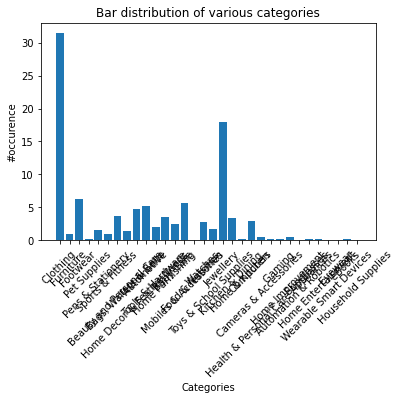

In [146]:
# Bar Chart
plt.bar(cat_count.keys(),cat_count.values())
plt.title('Bar distribution of various categories')
plt.xlabel('Categories')
plt.ylabel('#occurence')
plt.xticks(range(len(cat_count.keys())), cat_count.keys(), rotation=45)
plt.show()

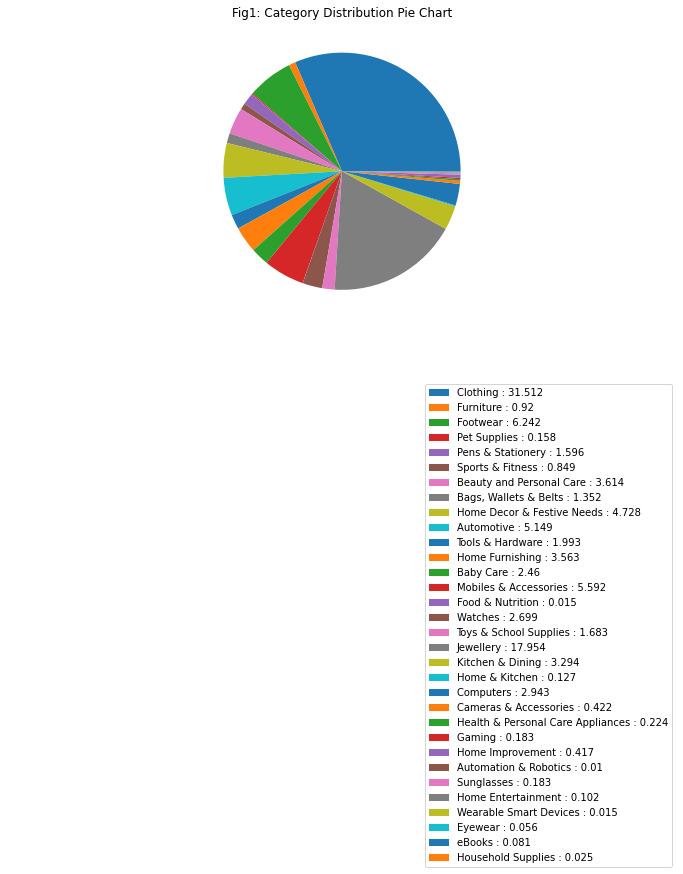

In [147]:
# Pie Chart
lbl =[cat+": "+str(round(cat_count[cat],3)) for cat in cat_count]
fig = plt.figure(4, figsize=(12,12))
ax = fig.add_subplot(211) 
patches,text = ax.pie(cat_count.values())
ax.set_title("Fig1: Category Distribution Pie Chart")
ax2 = fig.add_subplot(212)
ax2.axis("off") 
ax2.legend(patches, lbl, loc="best")
# plt.show()

### Model Setup

In [129]:
"""
This Function:
1) Collects the data in the form of features and labels
2) Applies a single Train-Test split
3) Fits the model to the train data
4) Predicts the categories corresponding to features in X_test
5) Gives a classification matrix showing Precision, Recall, F1 scores of each
   class along with their average values.
"""
def run_model_single_split(model,labelled,vect,categories_to_ignore=[],categories_to_merge=[],class_wt=False,class_model=""):
  x,y = [],[]
  for i in labelled:
    if i[1] in categories_to_ignore:
      continue
    else:
       merge_found = False
       for cat in categories_to_merge:
        if i[1] in cat:
          merge_found = True
          y.append(cat[0])
          break
       if not merge_found:
        y.append(i[1])
    x.append(' '.join(i[0]))

  le = preprocessing.LabelEncoder()
  y = le.fit_transform(y)
  uniq_labels = np.unique(y)

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=21)
  X_train_matrix = vect.fit_transform(X_train)

  if class_wt:
    all = y_train
    unique_classes = np.unique(all)
    print(len(unique_classes))

    c_w = class_weight.compute_class_weight('balanced', unique_classes, all)
    if class_model == "ComplementNB":
      model.fit(X_train_matrix,y_train,sample_weight=[c_w[i-1] for i in all])
    elif class_model == "XGBOOST":
      model = xgb.XGBClassifier(weights = [c_w[i-1] for i in all])
      model.fit(X_train_matrix,y_train)
  else:
    model.fit(X_train_matrix, y_train)

  X_test_matrix = vect.transform(X_test)
  predicted_result = model.predict(X_test_matrix)
  tgt = le.inverse_transform(list(set(y)))
  print(classification_report(y_test,predicted_result,target_names=tgt,labels = uniq_labels))
  return

In [116]:
"""
This Function:
1) Collects the data in the form of features and labels
2) Applies K-fold split of data
   i.e for each fold, on split is taken as test data and others as train data
3) Fits the model to the train data
4) Predicts the categories corresponding to features in X_test
5) Returns the mean precision, mean recall and mean f1 score of all the folds.
"""
def run_model(model,labelled,vect,categories_to_ignore=[],categories_to_merge=[],class_wt=False,class_model=""):
  x,y = [],[]
  for i in labelled:
    if i[1] in categories_to_ignore:
      continue
    else:
       merge_found = False
       for cat in categories_to_merge:
        if i[1] in cat:
          merge_found = True
          y.append(cat[0])
          break
       if not merge_found:
        y.append(i[1])
    x.append(' '.join(i[0]))

  le = preprocessing.LabelEncoder()
  y = le.fit_transform(y)
  uniq_labels = np.unique(y)

  precision,recall,f1 = [],[],[]
  kf = KFold(n_splits=5)
  x,y = shuffle(x,y, random_state=0)
  for train, test in kf.split(x):
    print(train,test)
    X_train, X_test, y_train, y_test = np.array(x)[train],np.array(x)[test],np.array(y)[train],np.array(y)[test]

    X_train_matrix = vect.fit_transform(X_train)

    if class_wt:
      all = y_train
      unique_classes = np.unique(all)
      print(len(unique_classes))

      c_w = class_weight.compute_class_weight('balanced', unique_classes, all)
      if class_model == "ComplementNB":
        model.fit(X_train_matrix,y_train,sample_weight=[c_w[i-1] for i in all])
      elif class_model == "XGBOOST":
        model = xgb.XGBClassifier(weights = [c_w[i-1] for i in all])
        model.fit(X_train_matrix,y_train)
    else:
      model.fit(X_train_matrix, y_train)

    X_test_matrix = vect.transform(X_test)
    predicted_result = model.predict(X_test_matrix)
    tgt = le.inverse_transform(list(set(y)))
    precision.append(precision_score(y_test, predicted_result, average='macro'))
    recall.append(recall_score(y_test, predicted_result, average='macro'))
    f1.append(f1_score(y_test, predicted_result, average='macro'))
  return mean(precision), mean(recall), mean(f1)

The selection of models used for this task include MultinomialNB, Support Vector Classifier, Random Forests and XGBoost. 

**Intuition**: MultinomialNB and SVM are well used in text classification tasks hence these are being used.For Random Forests and XGBoost, these methods involve an ensemble of decision trees which could be used to mitigate the imbalance present in the dataset.

As Random Forests and SVM already have support for balanced class weights, for XGBoost, we need to feed the class weights of each training sample while fitting the model. For the Naive Bayes case, there is an alternate model called Categorical Naive Bayes which is more suited for imbalanced classes, for which, class weights are shared as well.


For each type of model, it is run in two different cases:


*   A single split is done on the dataset into train and test splits. After   training and predicting the model on test data, we observe precision, recall and f1 scores of each class along with it's average
*   In this case, we use K fold split on the dataset, where we take one fold for test data and the remaining for train data. We average the precision, recall and f1 scores over all the folds and return the mean.



### Model 1: Multinomial NB

#### Using Count Vectorizer

In [133]:
vect = CountVectorizer()
model = MultinomialNB()
run_model_single_split(model,labelled,vect)

                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.92      0.99      0.96       186
                        Baby Care        0.82      0.61      0.70        98
            Bags, Wallets & Belts        0.81      0.48      0.60        54
         Beauty and Personal Care        0.87      0.92      0.89       136
            Cameras & Accessories        1.00      0.35      0.52        23
                         Clothing        0.98      0.99      0.98      1205
                        Computers        0.78      0.75      0.76       118
                          Eyewear        1.00      1.00      1.00         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        0.97      0.98      0.98       238
                        Furniture        0.94      0.94      0.94        31
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
vect = CountVectorizer()
model = MultinomialNB()
run_model(model,labelled,vect)

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8254316509044279, 0.677172984083955, 0.7177398778327815)

#### Using TF-IDF Vectorizer (Word Level)

In [135]:
vect = TfidfVectorizer()
model = MultinomialNB()
run_model_single_split(model,labelled,vect)

                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.94      0.96      0.95       186
                        Baby Care        0.97      0.38      0.54        98
            Bags, Wallets & Belts        1.00      0.07      0.14        54
         Beauty and Personal Care        1.00      0.58      0.73       136
            Cameras & Accessories        0.00      0.00      0.00        23
                         Clothing        0.84      1.00      0.91      1205
                        Computers        0.99      0.69      0.82       118
                          Eyewear        0.00      0.00      0.00         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        0.99      0.92      0.95       238
                        Furniture        0.95      0.58      0.72        31
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
vect = TfidfVectorizer()
model = MultinomialNB()
run_model(model,labelled,vect)

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.556675328848261, 0.39878732450468324, 0.42922535143292745)

#### Using Merged and Ignored Categories

In [57]:
ignore_categories = ['eBooks ','Pet Supplies ','Health & Personal Care Appliances ', 'Household Supplies ']
merge_categories = [['Sunglasses ', 'Eyewear '],['Kitchen & Dining ','Home & Kitchen  ']]


In [26]:
vect = CountVectorizer()
model = MultinomialNB()
run_model_single_split(model,labelled,vect,ignore_categories,merge_categories)

                             precision    recall  f1-score   support

                Automotive        0.92      0.98      0.95       197
                 Baby Care        0.77      0.62      0.69       100
     Bags, Wallets & Belts        0.85      0.56      0.67        63
  Beauty and Personal Care        0.93      0.94      0.93       141
     Cameras & Accessories        1.00      0.40      0.57        15
                  Clothing        0.98      0.98      0.98      1245
                 Computers        0.88      0.73      0.80       129
                  Footwear        0.97      0.94      0.96       241
                 Furniture        0.92      0.97      0.94        35
                    Gaming        0.60      0.60      0.60         5
            Home & Kitchen        1.00      0.33      0.50         6
Home Decor & Festive Needs        0.86      0.99      0.92       170
        Home Entertainment        0.00      0.00      0.00         4
           Home Furnishing       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
vect = TfidfVectorizer()
model = MultinomialNB()
run_model_single_split(model,labelled,vect,ignore_categories,merge_categories)

                             precision    recall  f1-score   support

                Automotive        0.94      0.95      0.94       197
                 Baby Care        0.97      0.39      0.56       100
     Bags, Wallets & Belts        1.00      0.08      0.15        63
  Beauty and Personal Care        1.00      0.68      0.81       141
     Cameras & Accessories        0.00      0.00      0.00        15
                  Clothing        0.86      1.00      0.92      1245
                 Computers        1.00      0.71      0.83       129
                  Footwear        1.00      0.93      0.96       241
                 Furniture        0.92      0.69      0.79        35
                    Gaming        0.00      0.00      0.00         5
            Home & Kitchen        0.00      0.00      0.00         6
Home Decor & Festive Needs        0.90      0.85      0.88       170
        Home Entertainment        0.00      0.00      0.00         4
           Home Furnishing       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 2: Complementary NB

#### Using Count Vectorizer

In [15]:
ignore_categories = ['eBooks ','Pet Supplies ','Health & Personal Care Appliances ', 'Household Supplies ']
merge_categories = [['Sunglasses ', 'Eyewear '],['Kitchen & Dining ','Home & Kitchen  ']]


In [130]:
vect = CountVectorizer()
model = ComplementNB()
run_model_single_split(model,labelled,vect,class_wt=True,class_model="ComplementNB")

32
                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.44      0.99      0.61       186
                        Baby Care        0.00      0.00      0.00        98
            Bags, Wallets & Belts        0.85      0.20      0.33        54
         Beauty and Personal Care        0.97      0.48      0.64       136
            Cameras & Accessories        1.00      0.43      0.61        23
                         Clothing        0.95      0.98      0.96      1205
                        Computers        1.00      0.26      0.42       118
                          Eyewear        0.00      0.00      0.00         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        0.79      0.99      0.88       238
                        Furniture        1.00      0.16      0.28        31
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
vect = CountVectorizer()
model = ComplementNB()
run_model(model,labelled,vect,class_wt=True,class_model="ComplementNB")

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]
31


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7748355212470442, 0.624994000186398, 0.6250430807996481)

#### Using TF-IDF vectorizer

In [36]:
vect = TfidfVectorizer()
model = ComplementNB()
run_model_single_split(model,labelled,vect,class_wt=True)

32
                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.94      0.97      0.96       186
                        Baby Care        0.57      0.82      0.67        98
            Bags, Wallets & Belts        0.86      0.94      0.90        54
         Beauty and Personal Care        0.97      0.89      0.93       136
            Cameras & Accessories        0.85      0.96      0.90        23
                         Clothing        1.00      0.94      0.97      1205
                        Computers        0.92      0.93      0.93       118
                          Eyewear        0.33      1.00      0.50         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        0.97      1.00      0.98       238
                        Furniture        0.77      0.97      0.86        31
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
vect = TfidfVectorizer()
model = ComplementNB()
run_model(model,labelled,vect,class_wt=True,class_model="ComplementNB")

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]
31


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7183077563139951, 0.6011018632583017, 0.5916240998503096)

### Model 3: XGBOOST classifier

#### Using Count Vectorizer

In [21]:
model = xgb.XGBClassifier()
vect = CountVectorizer()
run_model(model,labelled,vect)

                                    precision    recall  f1-score   support

                       Automotive        0.94      1.00      0.97       186
                        Baby Care        0.87      0.86      0.86        98
            Bags, Wallets & Belts        0.86      0.89      0.87        54
         Beauty and Personal Care        0.99      0.93      0.96       136
            Cameras & Accessories        0.95      0.87      0.91        23
                         Clothing        0.98      0.99      0.98      1205
                        Computers        0.96      0.92      0.94       118
                          Eyewear        1.00      1.00      1.00         1
                         Footwear        0.99      0.97      0.98       238
                        Furniture        0.97      0.97      0.97        31
                           Gaming        0.71      1.00      0.83         5
Health & Personal Care Appliances        1.00      1.00      1.00         9
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Using TF-IDF vectorizer (Word Level)

In [22]:
model = xgb.XGBClassifier()
vect = TfidfVectorizer()
run_model(model,labelled,vect)

                                    precision    recall  f1-score   support

                       Automotive        0.95      1.00      0.97       186
                        Baby Care        0.88      0.85      0.86        98
            Bags, Wallets & Belts        0.90      0.85      0.88        54
         Beauty and Personal Care        0.99      0.93      0.96       136
            Cameras & Accessories        0.96      0.96      0.96        23
                         Clothing        0.98      0.99      0.98      1205
                        Computers        0.89      0.98      0.94       118
                          Eyewear        1.00      1.00      1.00         1
                         Footwear        0.99      0.96      0.98       238
                        Furniture        1.00      0.90      0.95        31
                           Gaming        0.67      0.80      0.73         5
Health & Personal Care Appliances        1.00      1.00      1.00         9
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Using Merged and Ignored Categories

In [28]:
ignore_categories = ['eBooks ','Pet Supplies ','Health & Personal Care Appliances ', ]
merge_categories = [['Sunglasses ', 'Eyewear '],['Kitchen & Dining ','Home & Kitchen  ']]

In [31]:
model = xgb.XGBClassifier()
vect = CountVectorizer()
run_model(model,labelled,vect,ignore_categories,merge_categories)

                             precision    recall  f1-score   support

                Automotive        0.98      0.98      0.98       197
                 Baby Care        0.92      0.89      0.90       100
     Bags, Wallets & Belts        0.92      0.95      0.94        63
  Beauty and Personal Care        0.98      0.93      0.95       141
     Cameras & Accessories        0.93      0.93      0.93        15
                  Clothing        0.98      0.99      0.99      1245
                 Computers        0.99      0.92      0.96       129
                  Footwear        0.99      0.98      0.99       241
                 Furniture        0.90      1.00      0.95        35
                    Gaming        0.80      0.80      0.80         5
            Home & Kitchen        0.80      0.67      0.73         6
Home Decor & Festive Needs        0.90      0.98      0.94       170
        Home Entertainment        1.00      0.75      0.86         4
           Home Furnishing       

In [33]:
model = xgb.XGBClassifier()
vect = TfidfVectorizer()
# run_model(model,labelled,vect)
run_model(model,labelled,vect,ignore_categories,merge_categories)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                    precision    recall  f1-score   support

                       Automotive        0.95      1.00      0.97       186
                        Baby Care        0.88      0.85      0.86        98
            Bags, Wallets & Belts        0.90      0.85      0.88        54
         Beauty and Personal Care        0.99      0.93      0.96       136
            Cameras & Accessories        0.96      0.96      0.96        23
                         Clothing        0.98      0.99      0.98      1205
                        Computers        0.89      0.98      0.94       118
                          Eyewear        1.00      1.00      1.00         1
                         Footwear        0.99      0.96      0.98       238
                        Furniture        1.00      0.90      0.95        31
                           Gaming        0.67      0.80      0.73         5
Health & Personal Care Appliances        1.00      1.00      1.00         9
           

#### Handling imbalanced data

##### CountVectorizer

In [42]:
model = xgb.XGBClassifier()
vect = CountVectorizer()
# run_model(model,labelled,vect)
run_model(model,labelled,vect,class_wt=True,class_model="XGBOOST")

32
                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.94      1.00      0.97       186
                        Baby Care        0.87      0.86      0.86        98
            Bags, Wallets & Belts        0.86      0.89      0.87        54
         Beauty and Personal Care        0.99      0.93      0.96       136
            Cameras & Accessories        0.95      0.87      0.91        23
                         Clothing        0.98      0.99      0.98      1205
                        Computers        0.96      0.92      0.94       118
                          Eyewear        1.00      1.00      1.00         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        0.99      0.97      0.98       238
                        Furniture        0.97      0.97      0.97        31
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
model = xgb.XGBClassifier()
vect = CountVectorizer()
# run_model(model,labelled,vect)
run_model(model,labelled,vect,class_wt=True,class_model="XGBOOST")

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]
32
[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]
31
[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]
32
[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8941550545168043, 0.8260820702137625, 0.8480220940115212)

##### TF-IDF Vectorizer

In [41]:
model = xgb.XGBClassifier()
vect = TfidfVectorizer()
# run_model(model,labelled,vect)
run_model(model,labelled,vect,class_wt=True,class_model="XGBOOST")

32
                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.95      1.00      0.97       186
                        Baby Care        0.88      0.85      0.86        98
            Bags, Wallets & Belts        0.90      0.85      0.88        54
         Beauty and Personal Care        0.99      0.93      0.96       136
            Cameras & Accessories        0.96      0.96      0.96        23
                         Clothing        0.98      0.99      0.98      1205
                        Computers        0.89      0.98      0.94       118
                          Eyewear        1.00      1.00      1.00         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        0.99      0.96      0.98       238
                        Furniture        1.00      0.90      0.95        31
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [118]:
model = xgb.XGBClassifier()
vect = TfidfVectorizer()
# run_model(model,labelled,vect)
run_model(model,labelled,vect,class_wt=True,class_model="XGBOOST")

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]
32
[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]
31


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]
32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]
32


(0.880764859758589, 0.8305019365986742, 0.8476183773043438)

### Model 4: Random Forest Classifier

In [46]:
model = RandomForestClassifier(random_state=0, class_weight='balanced')
vect = CountVectorizer()
run_model(model,labelled,vect,ignore_categories,merge_categories)

                             precision    recall  f1-score   support

                Automotive        0.99      0.97      0.98       197
                 Baby Care        0.96      0.81      0.88       100
     Bags, Wallets & Belts        0.94      0.94      0.94        63
  Beauty and Personal Care        0.99      0.95      0.97       141
     Cameras & Accessories        1.00      0.87      0.93        15
                  Clothing        0.97      1.00      0.99      1245
                 Computers        0.96      0.94      0.95       129
                  Footwear        1.00      0.98      0.99       241
                 Furniture        0.95      1.00      0.97        35
                    Gaming        0.67      0.80      0.73         5
            Home & Kitchen        1.00      0.67      0.80         6
Home Decor & Festive Needs        0.95      0.97      0.96       170
        Home Entertainment        1.00      0.50      0.67         4
           Home Furnishing       

In [47]:
model = RandomForestClassifier(random_state=0, class_weight='balanced')
vect = TfidfVectorizer()
run_model(model,labelled,vect,ignore_categories,merge_categories)

                             precision    recall  f1-score   support

                Automotive        0.99      0.98      0.98       197
                 Baby Care        0.96      0.77      0.86       100
     Bags, Wallets & Belts        0.92      0.89      0.90        63
  Beauty and Personal Care        0.99      0.95      0.97       141
     Cameras & Accessories        1.00      0.80      0.89        15
                  Clothing        0.97      1.00      0.98      1245
                 Computers        0.94      0.92      0.93       129
                  Footwear        0.98      0.99      0.99       241
                 Furniture        0.92      0.97      0.94        35
                    Gaming        0.75      0.60      0.67         5
            Home & Kitchen        1.00      0.50      0.67         6
Home Decor & Festive Needs        0.90      0.98      0.94       170
        Home Entertainment        1.00      0.25      0.40         4
           Home Furnishing       

In [111]:
model = RandomForestClassifier(random_state=0, class_weight='balanced')
vect = TfidfVectorizer()
run_model(model,labelled,vect)

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8887708095993384, 0.7958185210893937, 0.8259700505008757)

In [114]:
model = RandomForestClassifier(random_state=0, class_weight='balanced')
vect = CountVectorizer()
run_model(model,labelled,vect)

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8946896100103311, 0.8256449554317796, 0.8496130693841077)

### Model 5: SVM

In [47]:
model = svm.SVC(kernel="linear")
vect = CountVectorizer()
run_model(model,labelled,vect,ignore_categories,merge_categories)

                             precision    recall  f1-score   support

     Automation & Robotics        0.00      0.00      0.00         0
                Automotive        0.99      0.95      0.97       191
                 Baby Care        0.94      0.95      0.95        88
     Bags, Wallets & Belts        0.97      0.97      0.97        58
  Beauty and Personal Care        0.96      0.99      0.98       130
     Cameras & Accessories        1.00      0.88      0.94        17
                  Clothing        0.99      1.00      0.99      1211
                 Computers        0.96      0.98      0.97       110
          Food & Nutrition        0.00      0.00      0.00         0
                  Footwear        1.00      0.99      0.99       268
                 Furniture        0.97      0.92      0.94        36
                    Gaming        0.83      0.83      0.83         6
            Home & Kitchen        0.75      0.50      0.60         6
Home Decor & Festive Needs       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
model = svm.SVC(kernel="linear")
vect = TfidfVectorizer()
run_model(model,labelled,vect,ignore_categories,merge_categories)

                             precision    recall  f1-score   support

     Automation & Robotics        0.00      0.00      0.00         0
                Automotive        0.98      0.98      0.98       191
                 Baby Care        0.97      0.85      0.91        88
     Bags, Wallets & Belts        0.95      0.97      0.96        58
  Beauty and Personal Care        0.97      0.99      0.98       130
     Cameras & Accessories        1.00      0.94      0.97        17
                  Clothing        0.98      1.00      0.99      1211
                 Computers        0.95      1.00      0.97       110
          Food & Nutrition        0.00      0.00      0.00         0
                  Footwear        1.00      0.98      0.99       268
                 Furniture        0.95      0.97      0.96        36
                    Gaming        1.00      0.83      0.91         6
            Home & Kitchen        1.00      0.67      0.80         6
Home Decor & Festive Needs       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Handling Imbalances

In [45]:
model = svm.SVC(kernel="linear",class_weight="balanced")
vect = CountVectorizer()
run_model(model,labelled,vect)

                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.95      0.98      0.97       186
                        Baby Care        0.89      0.88      0.88        98
            Bags, Wallets & Belts        0.94      0.87      0.90        54
         Beauty and Personal Care        0.98      0.95      0.96       136
            Cameras & Accessories        0.88      0.96      0.92        23
                         Clothing        0.99      0.99      0.99      1205
                        Computers        0.95      0.94      0.94       118
                          Eyewear        1.00      1.00      1.00         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        1.00      1.00      1.00       238
                        Furniture        0.97      0.90      0.93        31
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
model = svm.SVC(kernel="linear",class_weight="balanced")
vect = TfidfVectorizer()
run_model(model,labelled,vect)

                                    precision    recall  f1-score   support

            Automation & Robotics        0.00      0.00      0.00         0
                       Automotive        0.95      0.99      0.97       186
                        Baby Care        0.85      0.87      0.86        98
            Bags, Wallets & Belts        0.94      0.91      0.92        54
         Beauty and Personal Care        0.96      0.97      0.97       136
            Cameras & Accessories        0.96      0.96      0.96        23
                         Clothing        0.99      0.99      0.99      1205
                        Computers        0.90      0.97      0.93       118
                          Eyewear        1.00      1.00      1.00         1
                 Food & Nutrition        0.00      0.00      0.00         0
                         Footwear        1.00      1.00      1.00       238
                        Furniture        0.97      0.90      0.93        31
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
model = svm.SVC(kernel="linear",class_weight="balanced")
vect = TfidfVectorizer()
print(run_model(model,labelled,vect))

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]
(0.9050505102341347, 0.8728180624291326, 0.8802403143850323)


In [113]:
model = svm.SVC(kernel="linear",class_weight="balanced")
vect = CountVectorizer()
print(run_model(model,labelled,vect))

[ 3935  3936  3937 ... 19669 19670 19671] [   0    1    2 ... 3932 3933 3934]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [3935 3936 3937 ... 7867 7868 7869]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [ 7870  7871  7872 ... 11801 11802 11803]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 19669 19670 19671] [11804 11805 11806 ... 15735 15736 15737]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[    0     1     2 ... 15735 15736 15737] [15738 15739 15740 ... 19669 19670 19671]
(0.8554687049947707, 0.83179765446033, 0.8357903716167211)
